## Imports

In [32]:
import os
import math
import keras
import random
import sklearn
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from keras.layers import RepeatVector, TimeDistributed, Dense, Dropout
from keras.layers import LSTM, Conv1D, Bidirectional, MaxPooling1D, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
# Routine to be sure to get reproductible results
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Load and format the time series

In [34]:
# Load the dataset
df = pd.read_csv('Data/wisconsin-employment-time-series.csv', header=0, squeeze=True, infer_datetime_format=True)
df = df.rename(columns={'Data': 'Employment figures'})
df['Month'] = pd.DatetimeIndex(df['Month'])
# Set 'Month' to be the index
df = df.set_index('Month')

## Visualize the time series

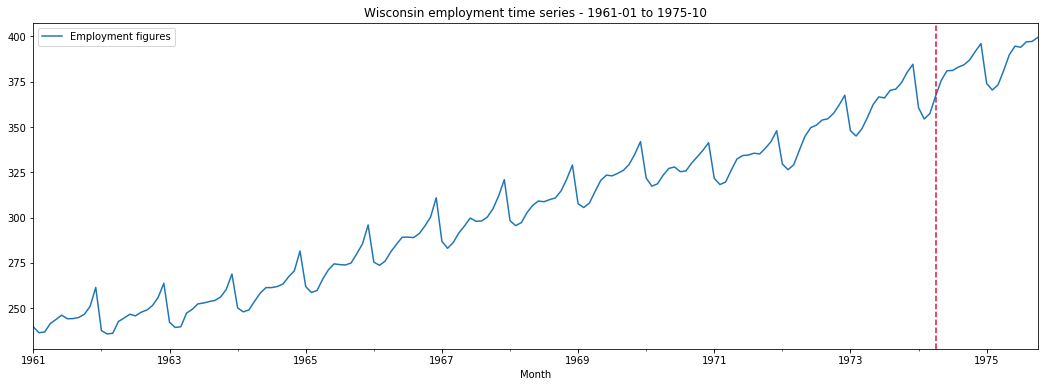

In [35]:
# Plot the time series
df.plot(colormap='tab10')
plt.title('Wisconsin employment time series - 1961-01 to 1975-10')
plt.axvline(x='1974-04', linestyle='--', c='crimson')
plt.gcf().set_size_inches(18,6)
plt.show()

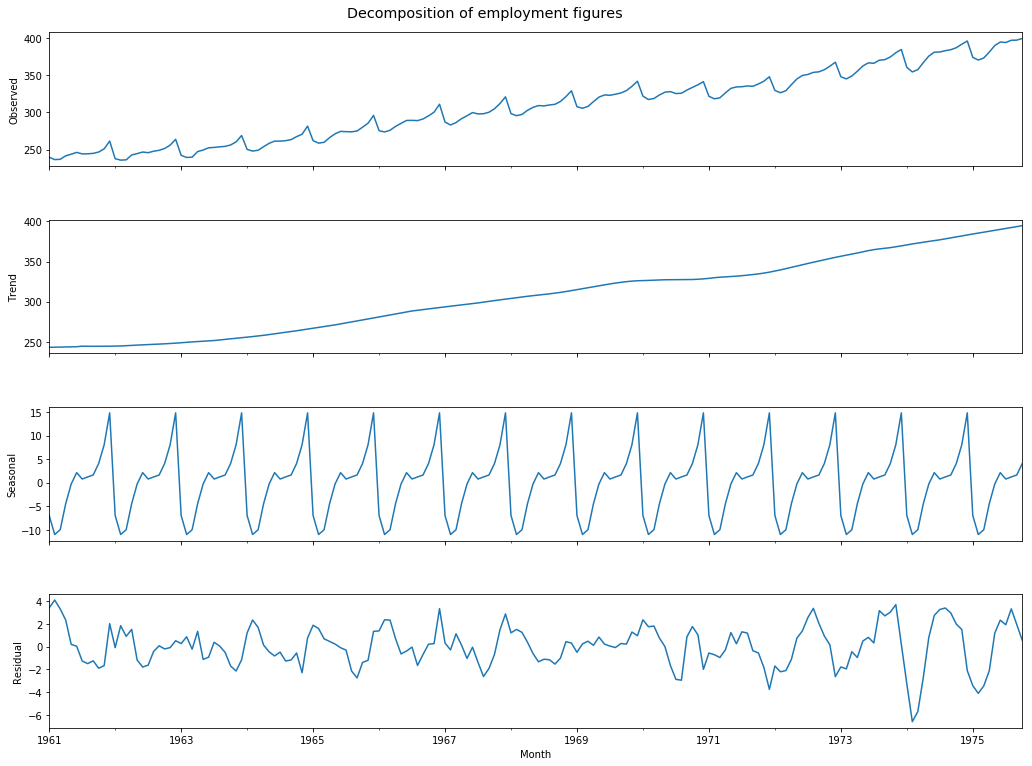

In [36]:
# Decompose time series
decomposition = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

# Plot the decomposition
decomposition.plot()
plt.suptitle('Decomposition of employment figures', size='x-large')
plt.subplots_adjust(top=0.95)
plt.gcf().set_size_inches(16,12)
plt.show()

## Preprocess the time series

### Scaling

In [37]:
# Scale the values using MinMaxScaler
obs = df['Employment figures'].values
obs = obs.reshape(len(obs), 1)
mm_scaler = MinMaxScaler().fit(obs)
obs_scale = mm_scaler.transform(obs).flatten()

### Hide the end of the time series
We hide the last 18 months of the time series in order to predict them and test the accuracy of the models using RMSE score.

In [38]:
obs_train = obs_scale[:obs_scale.shape[0]-18]
obs_test = obs_scale[obs_scale.shape[0]-18:]

## Find an optimal model

In [39]:
def split_sequence(sequence, window):
    """ This function splits the time series into a sequence of n_steps values
        used to predict the n_steps + 1 value. This transform the time series
        to a supervised learning problem. """
    # Initialize X and y
    X, y = [], []
    for i in range(len(sequence)):
        # Define the end of the observations
        end = i + window
        # Check for IndexOutOfBounds
        if end > len(sequence)-1:
            break
        # Add the observations sequence and the prediction
        X.append(sequence[i:end])
        y.append(sequence[end])
    # Return X and y
    return np.array(X), np.array(y)

In [40]:
def get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained only
        once on all known values. """
    # Get the observations and the targets
    X_train, y_train = split_sequence(obs_train, window)
    # Reshape to fit the model's input shape
    if(CNN):
        X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
    else:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    # Train the model on all known observations
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [41]:
def get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained at
        each time a new predictions get available."""
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the observations and the targets
        X_train, y_train = split_sequence(obs_train_, window)
        # Reshape to fit the model's input shape
        if(CNN):
            X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
        else:
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        # Train the model on all known observations
        model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [42]:
# We will use a window of size 50
window = 50
# Define the number of epochs
n_epochs = 200

### Architectures definition
The following implementations have been implemented using the help of this tutorial on LSTM development for Time Series. 
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

#### Vanilla LSTM Architecture
The Vanilla LSTM is the most basic LSTM architecture. It has a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [43]:
# Vanilla LSTM
van_model = Sequential()
van_model.add(LSTM(50, activation='relu', input_shape=(window, 1)))
van_model.add(Dense(1))
van_model.compile(optimizer='adam', loss='mse')
van_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### Stacked LSTM Architecture
A stacked LSTM architecture is such that many hidden layers can be stacked one on top of another.

In [44]:
# Stacked LSTM
st_model = Sequential()
st_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window, 1)))
st_model.add(LSTM(50, activation='relu'))
st_model.add(Dense(1))
st_model.compile(optimizer='adam', loss='mse')
st_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### Bidirectional LSTM Architecture
In Bidirectional LSTM architecture, we train two instead of one LSTMs on the input sequence. The first on the original input sequence and the second on a reversed copy of the input sequence.

In [45]:
# Bidirectional LSTM
bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, 1)))
bi_model.add(Dense(1))
bi_model.compile(optimizer='adam', loss='mse')
bi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


#### CNN LSTM Architecture
The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

In [46]:
# CNN LSTM
cnn_model = Sequential()
cnn_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                              input_shape=(None, int(window/2), 1)))
cnn_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_model.add(TimeDistributed(Flatten()))
cnn_model.add(LSTM(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 25, 64)      128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 768)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                163800    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 163,979
Trainable params: 163,979
Non-trainable params: 0
_________________________________________________________________


In [47]:
models = [van_model, st_model, bi_model, cnn_model]

### Test the models - Static approach
In this static approach we use the following scheme. We train the model on the known values and we fit the model to the 50 more recent known values to get the first prediction. Once we have this first prediction, it becomes a known values that we will use to compute the next prediction. Therefore, at the second iterative step, the obsevations will consisits of the 49 most recent initially known values plus the first prediction. And we keep going on like this until we have predicted all the missing values. Note that in this model we only train the model once at the begining instead of training it at each iterative step.

In [50]:
# Define the parameters
n_predictions = 18
rmses_static = []
col_name = ['Vanilla static preds', 'Stacked static preds', 'Bidirectional static preds', 'CNN static preds']

In [51]:
# Get the predictions and store the RMSE for each model
for i, model in enumerate(models):
    y_pred = get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale
    rmse_st = np.sqrt(mean_squared_error(df['Employment figures'].values, df[col_name[i]]))
    rmses_static.append(rmse_st)

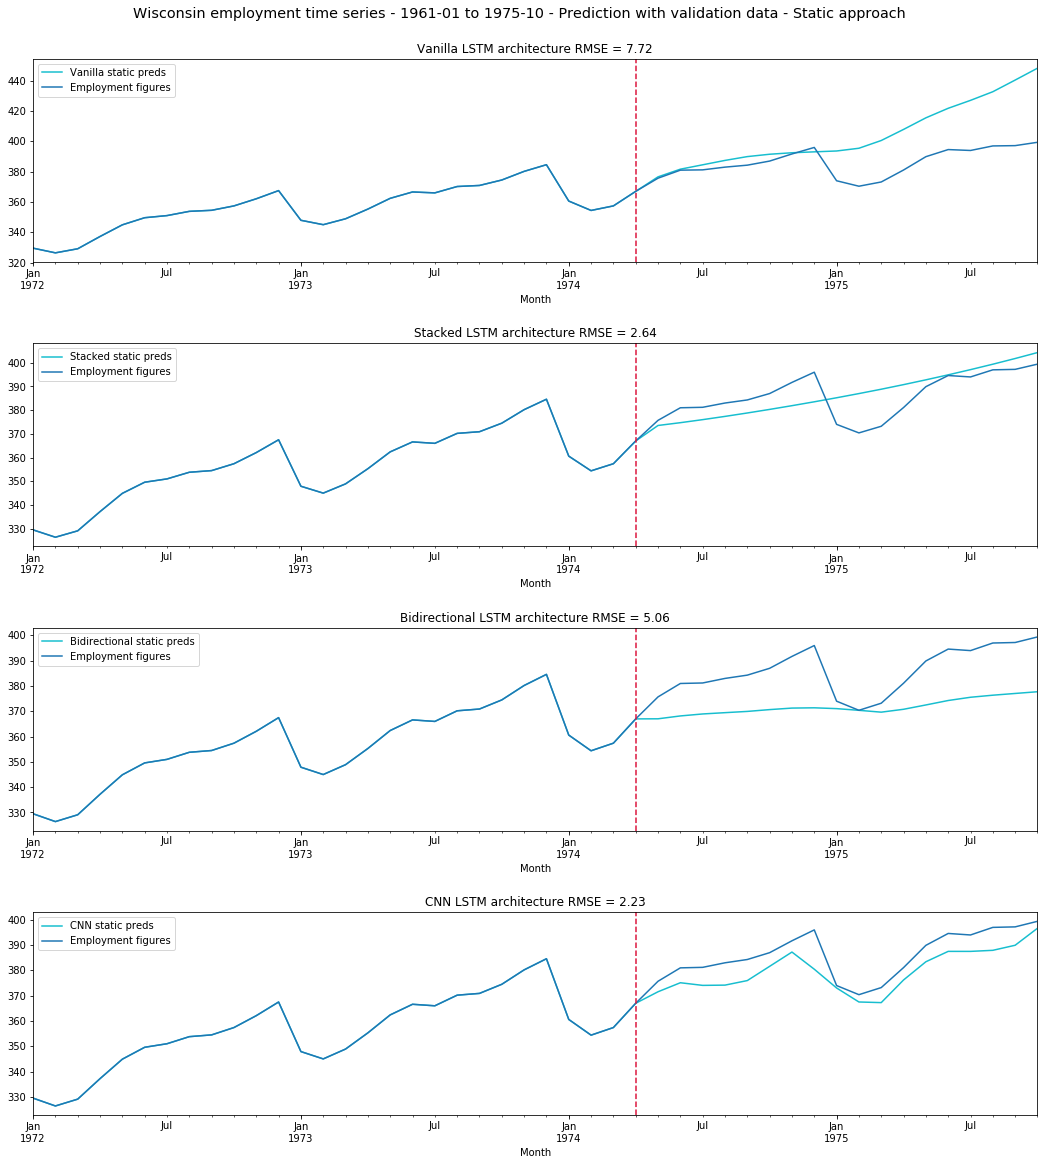

In [55]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture RMSE = {:.2f}', 'Stacked LSTM architecture RMSE = {:.2f}',
              'Bidirectional LSTM architecture RMSE = {:.2f}', 'CNN LSTM architecture RMSE = {:.2f}']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Static approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i].format(rmses_static[i]))
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.94)
plt.gcf().set_size_inches(18, 18)
plt.show()

### Test the models - Dynamic approach
In the dynamic approach, instead of training the model only once at the begining with the known values, we train a new model at each time we have computed a new prediction.

In [56]:
# Define the parameters
n_predictions = 18
rmses_dynamic = []
col_name = ['Vanilla dynamic preds', 'Stacked dynamic preds', 'Bidirectional dynamic preds', 'CNN dynamic preds']

In [57]:
# Get the predictions and store the RMSE for each model
for i, model in enumerate(models):
    y_pred = get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale
    rmse_dyn = np.sqrt(mean_squared_error(df['Employment figures'].values, df[col_name[i]]))
    rmses_dynamic.append(rmse_dyn)

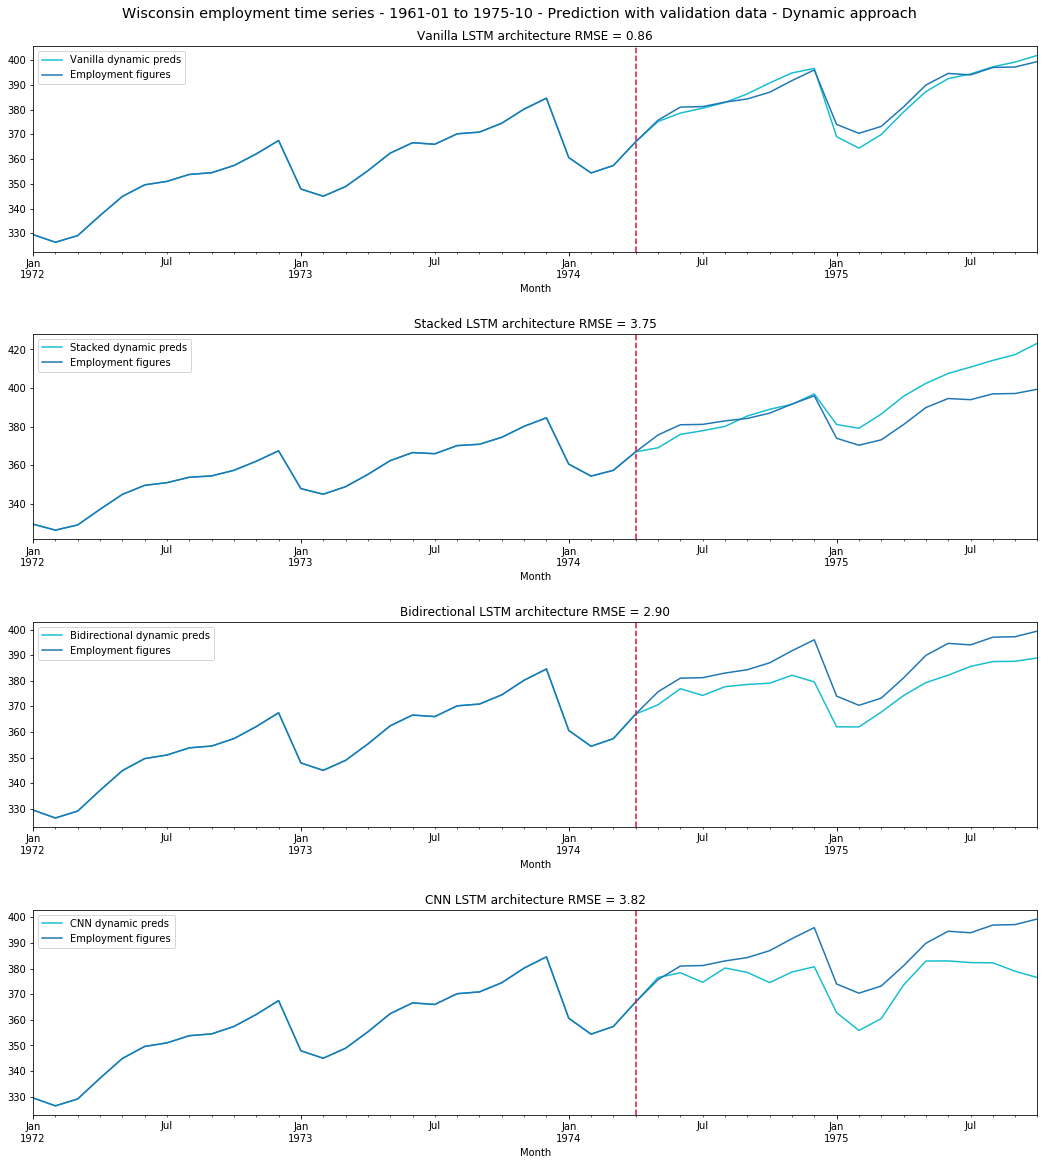

In [62]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture RMSE = {:.2f}', 'Stacked LSTM architecture RMSE = {:.2f}',
              'Bidirectional LSTM architecture RMSE = {:.2f}', 'CNN LSTM architecture RMSE = {:.2f}']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Dynamic approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i].format(rmses_dynamic[i]))
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.95)
plt.gcf().set_size_inches(18, 18)
plt.show()

### Compare the Mean Squared Errors

In [63]:
rmses = {'Static': rmses_static, 'Dynamic': rmses_dynamic}
index = ['Vanilla', 'Stacked', 'Bidirectional', 'CNN']
df_comp = pd.DataFrame(rmses)
df_comp.index = index
df_comp

,Static,Dynamic
Vanilla,7.724848,0.860598
Stacked,2.636156,3.750384
Bidirectional,5.057296,2.902517
CNN,2.230783,3.820939


## 2 years forecast

In [64]:
# Use a copy of the original dataset
df_forecast = df[['Employment figures']]
# Add the dates for the next 24 months
datelist = [d.strftime('%Y-%m-01') for d in pd.date_range('1975-11', periods=24, freq='M').tolist()]
df_ = pd.DataFrame(datelist)
dt_index = pd.DatetimeIndex(df_[0])
df_forecast = df_forecast.append(pd.DataFrame(np.zeros(len(dt_index)), index=dt_index, columns=['Employment figures']))

In [65]:
# Define the parameters
n_predictions = 24
col_name = ['Vanilla forecast', 'Stacked forecast','Bidirectional forecast', 'CNN forecast']

In [66]:
# Get the predictions and store them
for i, model in enumerate(models):
    # Get the prediction
    y_pred = get_predictions_dynamic(model, obs_scale, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df_forecast[col_name[i]] = y_pred_unscale

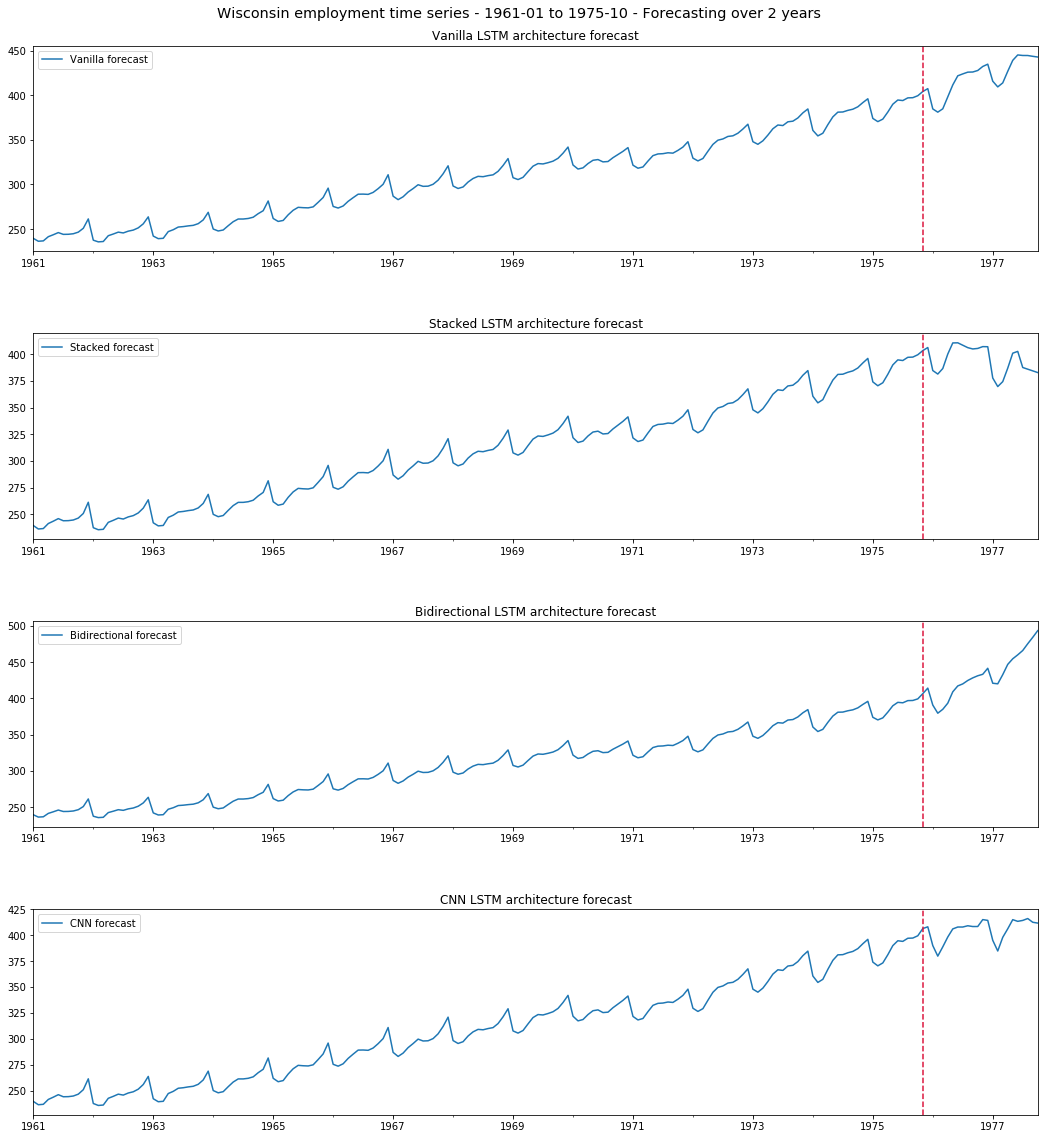

In [67]:
sub_titles = ['Vanilla LSTM architecture forecast', 'Stacked LSTM architecture forecast',
              'Bidirectional LSTM architecture forecast', 'CNN LSTM architecture forecast']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Forecasting over 2 years'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df_forecast[[col_name[i]]].plot(ax=ax[i], colormap='tab10')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1975-11', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.95)
plt.gcf().set_size_inches(18, 18)
plt.show()